<a href="https://colab.research.google.com/github/ikhlas15/ATHENS-AI-Medical-Imaging/blob/main/H08_data_augmentation_and_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 08: Data Augmentation and Preprocessing for Medical Imaging**

### **Course**: Artificial Intelligence in Medical Imaging: From Fundamentals to Applications

***

## **1. Introduction**

Welcome to Notebook 08! So far, we have trained a baseline model on "clean" data. However, real-world medical data is never perfect, and deep learning models are notoriously data-hungry. This is where **data augmentation** and **preprocessing** become two of the most critical skills in your toolkit.

**Data augmentation** is the process of artificially expanding your training dataset by creating modified copies of your images. This teaches the model to be robust to variations it might see in real clinical practice, such as differences in patient positioning, imaging equipment, and noise. A model trained with good augmentation is less likely to overfit and will generalize better to new, unseen data.

#### **What you will learn today:**
*   The importance of data augmentation for building robust medical AI models.
*   How to design a preprocessing pipeline for medical images.
*   To implement common augmentation techniques (rotation, flipping, brightness/contrast changes) using `torchvision.transforms`.
*   To use **Albumentations**, a powerful, high-performance library for advanced image augmentation.
*   The importance of choosing clinically plausible augmentations.

***

## **2. Setup: Installing and Importing Libraries**

We will need `albumentations`, a library specifically designed for fast and flexible image augmentations.

In [ ]:
# Install required packages
!pip install torch torchvision medmnist albumentations

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import albumentations as A
# TODO: import (helper to convert NumPy image to PyTorch tensor)
from albumentations.pytorch import ...
import numpy as np
import cv2
import matplotlib.pyplot as plt
# import  PneumoniaMNIST dataset
from medmnist import ..

# Set our standard random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Define our device
device = ...("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 9.3 MB/s eta 0:00:00
Using device: cuda


***

## **3. The Preprocessing Pipeline**

Before any augmentation, we need a consistent preprocessing pipeline. For most deep learning models, this involves two key steps:
1.  **Converting to a Tensor:** Transforming the image from a NumPy array or PIL Image into a PyTorch `Tensor`.
2.  **Normalizing:** Scaling the pixel values to a standard range (e.g.,  or [-1, 1]). This helps stabilize training.

Let's define a simple preprocessing pipeline that we will apply *after* augmentation.


In [ ]:
# This pipeline will be applied at the end of our augmentation sequence
# It converts the image to a tensor and normalizes it.
preprocess_pipeline = T.Compose([
    T.ToTensor(), # Converts a PIL Image or numpy.ndarray to a tensor and scales it to [0.0, 1.0]
    T....(mean=[0.5], std=[0.5]) # Normalizes the tensor to the range [-1.0, 1.0]
])

***

## **4. Data Augmentation with `torchvision.transforms`**

`torchvision` provides a set of common and easy-to-use augmentation functions. Let's create an augmentation pipeline.

### **4.1. Defining the Augmentation Pipeline**
We will combine several transformations. Each time an image is requested from the dataset, these transforms will be applied with random parameters.


In [ ]:
# TODO: define a sequence of image augmentations using torchvision
train_transforms_torchvision = T.Compose([
    # Geometric transformations
    T.RandomHorizontalFlip(p=0.5), # Randomly flip the image horizontally
    T.RandomRotation(degrees=10), # Randomly rotate the image by up to 10 degrees
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)), # Randomly shift the image

    # Color (intensity) transformations
    T....(brightness=0.2, contrast=0.2), # Randomly change brightness and contrast

    # Finally, apply our preprocessing pipeline
    preprocess_pipeline
])

### **4.2. Visualizing the Augmented Images**
Let's apply these transforms to our PneumoniaMNIST dataset and see what the augmented images look like. Notice how a single original image can generate a virtually infinite number of variations.


100%|██████████| 4.17M/4.17M [00:08<00:00, 506kB/s]


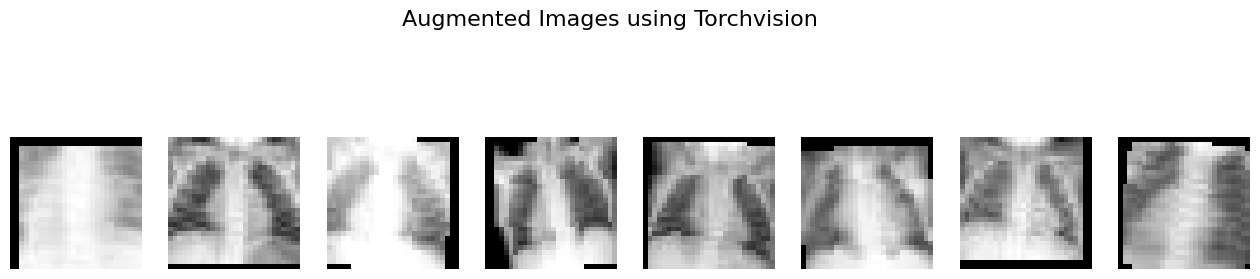

In [ ]:
# Load the dataset WITH the augmentation pipeline
augmented_dataset = PneumoniaMNIST(split='train', transform=..., download=...)
augmented_loader = DataLoader(dataset=..., batch_size=8, shuffle=...)

# Get one batch of augmented images
images, labels = next(iter(augmented_loader))

# Visualize them
def show_augmented_images(images, title):
    plt.figure(figsize=(16, 4))
    plt.suptitle(title, fontsize=16)
    for i in range(8):
        plt.subplot(1, 8, i+1)
        # Un-normalize for visualization
        img = ... * 0.5 + 0.5
        plt.imshow(img.squeeze(), cmap="gray")
        plt.axis('off')
    plt.show()

show_augmented_images(images, "Augmented Images using Torchvision")

*Each image above is a slightly different version of an original X-ray, teaching our model to recognize pneumonia regardless of small changes in orientation or brightness.*

***

## **5. Advanced Augmentations with `Albumentations`**

While `torchvision` is great for simple cases, **`Albumentations`** is a faster, more powerful library that is a favorite in the computer vision community, especially for medical imaging. It offers a wider variety of transformations and is optimized for performance.

### **5.1. Defining an `Albumentations` Pipeline**
The syntax is very similar, but `Albumentations` operates on NumPy arrays by default. The final step is `ToTensorV2()`, which converts the augmented NumPy array to a PyTorch tensor.


*Each image above is a slightly different version of an original X-ray, teaching our model to recognize pneumonia regardless of small changes in orientation or brightness.*

***

## **5. Advanced Augmentations with `Albumentations`**

While `torchvision` is great for simple cases, **`Albumentations`** is a faster, more powerful library that is a favorite in the computer vision community, especially for medical imaging. It offers a wider variety of transformations and is optimized for performance.

### **5.1. Defining an `Albumentations` Pipeline**
The syntax is very similar, but `Albumentations` operates on NumPy arrays by default. The final step is `ToTensorV2()`, which converts the augmented NumPy array to a PyTorch tensor.


In [ ]:
# Define a more advanced augmentation pipeline with Albumentations
train_transforms_albumentations = A.Compose([
    # TODO: Random horizontal flip
    A. ...,
    A.Rotate(limit=15, p=0.7),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.8),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5), # Add realistic sensor noise
    A.GridDistortion(p=0.3), # Apply grid distortion

    # Normalization and conversion to tensor must be at the end
    A. ...(mean=(0.5,), std=(0.5,)),
   # TODO: convert to a PyTorch tensor using Albumentations way

])

/tmp/ipython-input-1591608213.py:6: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.5), # Add realistic sensor noise


### **5.2. Integrating `Albumentations` with a PyTorch `Dataset`**
Because `Albumentations` works with NumPy arrays, we need a small wrapper around the standard `medmnist` dataset. This custom `Dataset` class will fetch an image, convert it to a NumPy array, and then pass it to our `Albumentations` pipeline.


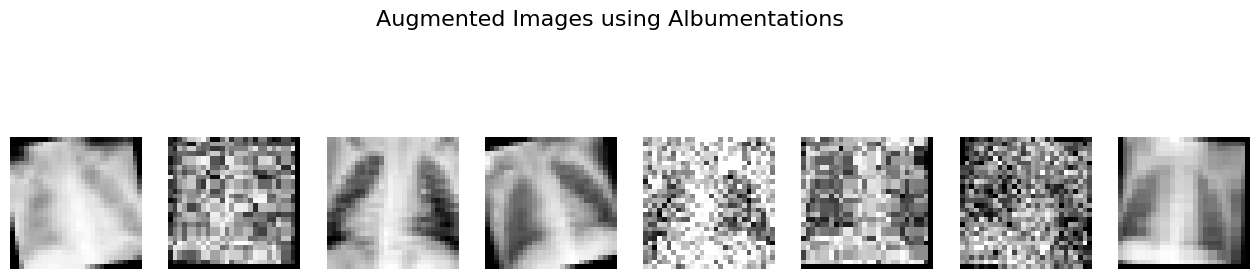

In [ ]:
class MedMNISTAlbumentationsDataset(Dataset):
    def __init__(self, medmnist_dataset, transform=None):
        self.medmnist_dataset = ...
        self.transform = transform

    def __len__(self):
        return len(self.medmnist_dataset)

    def __getitem__(self, idx):
        # Get the PIL image and label from the original dataset
        image, label = self.medmnist_dataset[...]

        # Convert the PIL image to a NumPy array
        image =

        # Apply the Albumentations transforms
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
         # TODO: return transformed image and label as tensor
        return ..., ... .long()

# Load the original dataset without any transforms
original_train_dataset = PneumoniaMNIST(split='train', download=False)

# TODO: wrap it with our custom Albumentations dataset
albumentations_dataset = MedMNISTAlbumentationsDataset(
    medmnist_dataset=...,
    transform=train_transforms_albumentations
)

# Create a DataLoader
albumentations_loader = ...(dataset=albumentations_dataset, batch_size=8, shuffle=True)

# Visualize the results
images, labels = next(iter(...))
show_augmented_images(images, "Augmented Images using Albumentations")

*Notice the more complex transformations like noise and distortion, which `torchvision` doesn't provide out of the box.*

***

## **6. Clinical Considerations and Best Practices**

Data augmentation is powerful, but it must be done carefully in a medical context. "Garbage in, garbage out" applies here.

*   **Plausibility is Key:** The transformations should mimic real-world variations. For example, flipping a chest X-ray horizontally is usually fine, but flipping it vertically is not anatomically possible. For an MRI of the brain, even a horizontal flip might be invalid if you are trying to distinguish between the left and right hemispheres.
*   **Don't Change the Label:** The augmentation must not change the diagnosis. Drastically changing the contrast or adding too much noise could obscure the pathology, confusing the model.
*   **Beware of Artifacts:** Be careful not to create unrealistic artifacts. For example, when rotating an image, the empty corners are often filled with black pixels. This is an artifact the model might incorrectly learn to associate with a certain class.
*   **Test-Time Augmentation (TTA):** For even more robust predictions at inference time, you can create multiple augmented versions of a single test image and average their predictions.

***

## **7. Summary and Next Steps**

**Challenge**: Go back to the baseline model from Notebook 07. Train it three times: once with no augmentation, once with the `torchvision` pipeline, and once with the `Albumentations` pipeline. Plot the validation accuracy curves for all three experiments on the same graph. You should see a significant improvement in performance and stability with augmentation!

In the next notebook, **`09_evaluation_metrics.ipynb`**, we will dive deep into how to properly evaluate your model's performance beyond simple accuracy, focusing on metrics that are crucial for building trustworthy medical AI systems.
